# CNN image classification in Pytorch using CIFAR-10 database

In [10]:
import os
import torch
import numpy as np
from matplotlib import pyplot as plt
from torch.autograd import Variable
%matplotlib inline
import torchvision
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torchsummary import summary
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [3]:
batch_size_train = 64
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
trainset = CIFAR10('.pytorch/CIGAR10', train=True, transform=transform_train, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train, shuffle=True, num_workers=2)

testset = CIFAR10('.pytorch/CIGAR10', train=False, transform=transform_test, download=True)
testloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train, shuffle=False, num_workers=2)

Using downloaded and verified file: .pytorch/CIGAR10\cifar-10-python.tar.gz
Extracting .pytorch/CIGAR10\cifar-10-python.tar.gz to .pytorch/CIGAR10
Files already downloaded and verified


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
import torch.nn as nn

class CNN(nn.Module):
    """CNN"""
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.SELU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.SELU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.SELU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.SELU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.SELU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.SELU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc = nn.Sequential(
        nn.Dropout(p=0.1),
        nn.Linear(4096, 1024),
        nn.SELU(inplace=True),
        nn.Linear(1024, 512),
        nn.SELU(inplace=True),
        nn.Dropout(p=0.1),
        nn.Linear(512, 10)
        )

    def forward(self,x ):
        x = self.conv(x)
        x = self.fc(x.view(x.size(0),-1))
        return x

model = CNN()
model.to(device)
summary(model, input_size=iter(trainloader).next()[0][0].size())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              SELU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
              SELU-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              SELU-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,584
             SELU-11          [-1, 128, 16, 16]               0
        MaxPool2d-12            [-1, 128, 8, 8]               0
        Dropout2d-13            [-1, 128, 8, 8]               0
           Conv2d-14            [-1, 25

In [43]:
if os.path.isdir('checkpoint'):
    model.load_state_dict(torch.load('./checkpoint/ckpt.t7', map_location=torch.device(device)))

In [7]:
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters(), lr=0.05, weight_decay=0.001)
train_tracker, test_tracker, accuracy_tracker = [], [], []

for epoch in range(30):

    running_loss = 0.0
    for _, (inputs, labels) in enumerate(trainloader, 1):
        # get the inputs
        inputs = inputs.to(device)
        labels = labels.to(device)


        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        if epoch > 16:
            for group in optimizer.param_groups:
                for p in group['params']:
                    state = optimizer.state[p]
                    if state['step'] >= 1024:
                        state['step'] = 1000
        optimizer.step()


        # print statistics
        running_loss += loss.item()

    # Normalizing the loss by the total number of train batches
    running_loss /= len(trainloader)

    # Calculate training/test set accuracy of the existing model
    test_loss = 0
    num_correct = 0
    total = 0
    for _, (images, labels) in enumerate(testloader,1):
        images = images.to(device)
        labels = labels.to(device)

        logps = model(images)
        batch_loss = criterion(logps, labels)
        test_loss += batch_loss.item()

        output = logps
        pred = torch.argmax(output, 1)
        total += labels.size(0)
        num_correct += (pred == labels).sum().item()

    test_tracker.append(test_loss/len(testloader))
    print(f"Test loss: {test_loss/len(testloader)} | ", end='')
    accuracy_tracker.append(num_correct/total)
    print(f'Accuracy : {num_correct/total}')

    print("Iteration: {0} | Loss: {1} | Test accuracy: {2}%".format(epoch+1, running_loss,  num_correct * 100 / total))

    # save model
    if epoch % 3 == 0:
        print('==> Saving model ...')

        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(model.state_dict(), './checkpoint/ckpt.t7')

print('==> Finished Training ...')

Test loss: 1.2588167474855243 | Accuracy : 0.55044
Iteration: 1 | Loss: 1.4292444387817627 | Test accuracy: 55.044%
==> Saving model ...


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


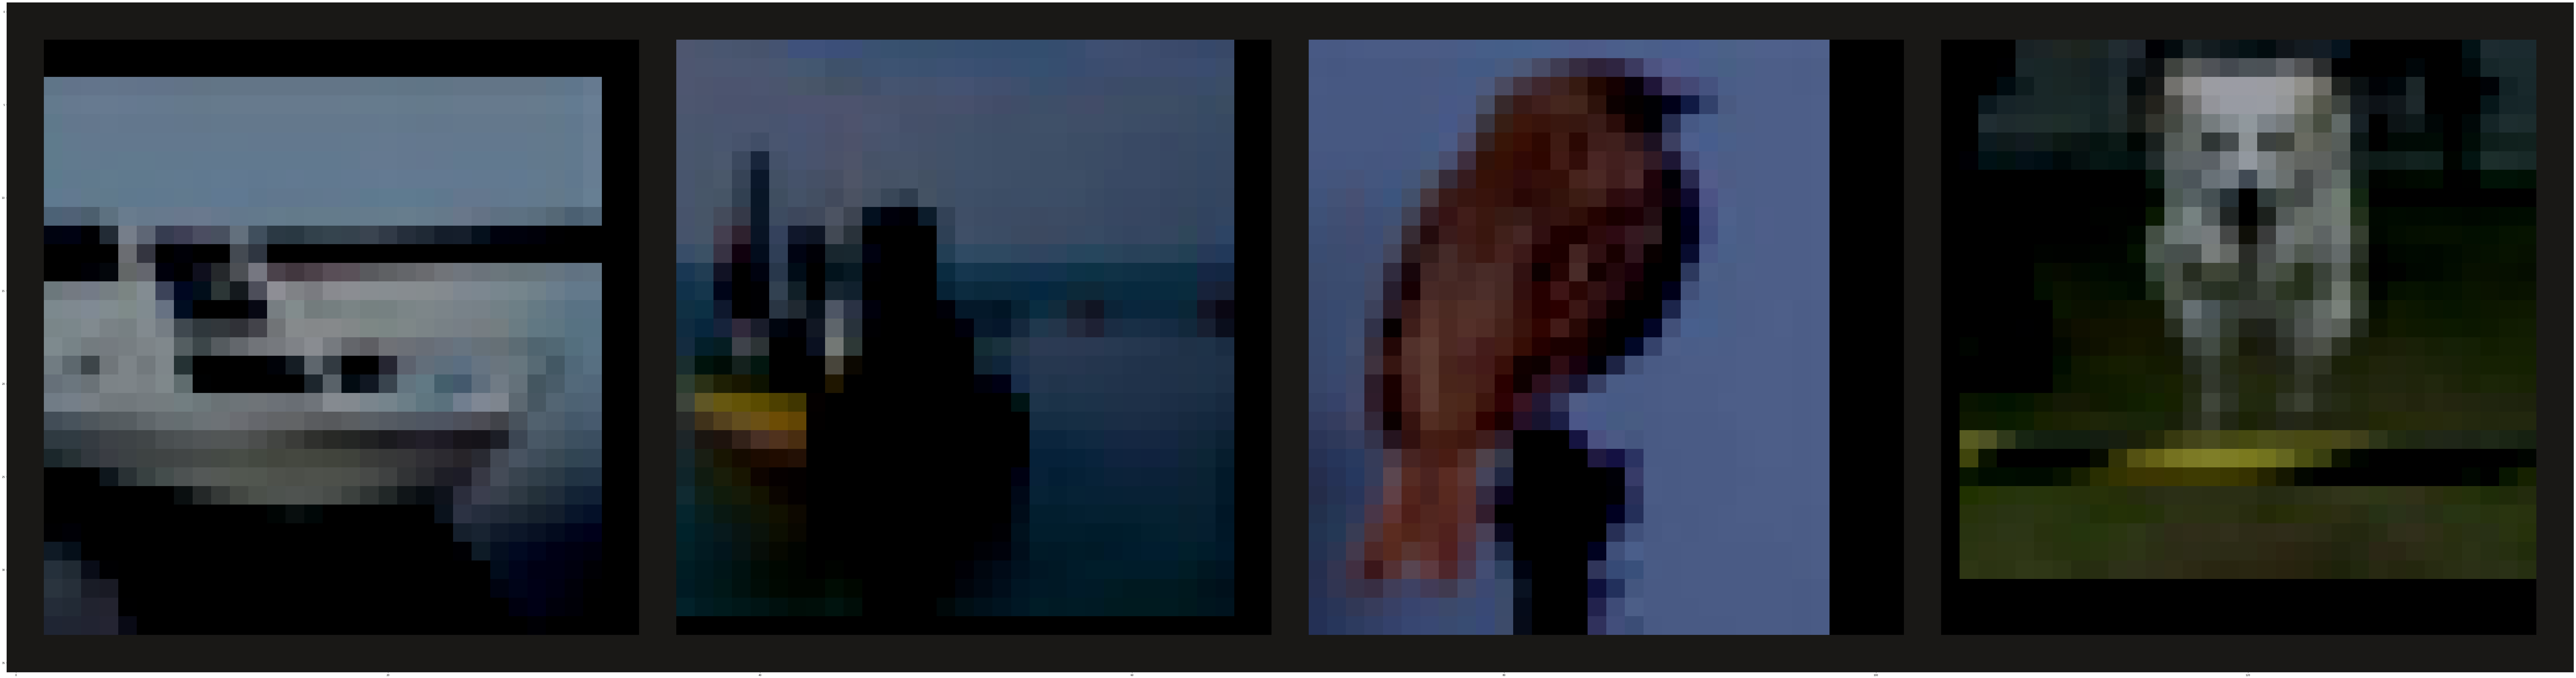

0: ship 1: ship 2: bird 3: dog


In [67]:
invTrans = transforms.Compose([
               transforms.Normalize((-0.4914, -0.4822, -0.4465), (1/0.2023, 1/0.1994, 1/0.2010)),
           ])

def imshow(img):
    img = invTrans(img)    # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (200,50))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = dataiter.next()
images, labels = dataiter.next()
images, labels = dataiter.next()
images, labels = images[0:4], labels[0:4]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(' '.join([f'{j}: {classes[labels[j]]}' for j in range(4)]))

In [69]:
with torch.no_grad():
    outputs = model(images)
    pred = torch.argmax(outputs, 1)
    print('Predicted', ' '.join([f'{j}: {classes[pred[j]]}' for j in range(4)]))

Predicted 0: ship 1: deer 2: bird 3: dog
